In this project I am going to train a LogisticRegression estimator for sentiment analysis to predict whether tweets are positive or negative and the main focus will be on emoji and emotions. 
The feature extraction part will be implemented completely  from scratch. I will cover the following: <br>

* Data Visualization
* Data Preprocessing (Tokenization, Stemming, Removing stopwords and punctuations, Convert to Lowercase etc)
* Emoji and Emotion Analysis (visualize the most important emojis/emotions, removing useless emojis/emotions etc)
* Feature Extraction
* Outlier Removal
* Model Training
* Model Evaluation
* Make predictions on new data
* Error Analysis

In [ ]:
!pip install emoji

In [1]:
# import libraries that are needed

import nltk
from os import getcwd
import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 
import random
import emoji
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [2]:
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

## Step 1 : Load and explore the dataset

In [3]:
# download english stopwords using nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loriz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# get the dataset (positive and negative tweets) from twitter_samples package
nltk.download('twitter_samples')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# print the amount of positive tweets
print(len(all_positive_tweets))

# print the amount of negative tweets
print(len(all_negative_tweets))

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\loriz\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


5000
5000


* The `twitter_samples` contains subsets of 5,000 positive tweets, 5,000 negative tweets

In [5]:
# print first 5 positive tweets
print(all_positive_tweets[:5])

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)', '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!', '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!', '@97sides CONGRATS :)', 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']


In [6]:
# print first 5 negative tweets
print(all_negative_tweets[:5])

['hopeless for tmr :(', "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(", '@Hegelbon That heart sliding into the waste basket. :(', '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too', 'Dang starting next week I have "work" :(']


In [7]:
# print a random positive tweet in green color
print('\033[92m' + all_positive_tweets[random.randint(0,5000)])

# print a random negative tweet in red color
print('\033[91m' + all_negative_tweets[random.randint(0,5000)])

@shraddhaa9 btw will you remember... :)
Cold+Cough= :(


In [8]:
# merge entire data (positive and negative tweets) into 1 single list
all_tweets = all_positive_tweets + all_negative_tweets
print(all_tweets[:5])

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)', '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!', '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!', '@97sides CONGRATS :)', 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']


In [9]:
# create the labels for all positive and negative tweets (1 means positive and 0 negative)
all_labels = np.append(np.ones((len(all_positive_tweets), 1)),
                       np.zeros((len(all_negative_tweets), 1)), axis=0)

# Print first 3 labels
print(all_labels[:3])

# Print labels from index 5003 till 5005
print(all_labels[5003:5006])

# Print shape of all_labels
print(all_labels.shape)

[[1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]]
(10000, 1)


## Step 2 : Data Visualization and Data Preprocessing

* Before visualising the data, we have to preprocess the tweets (perform tokenization, lowercasing, stemming, removing stopwords etc). This will be done using `process_tweet()` function.
* `process_tweet()`: cleans the text, tokenizes it into separate words, removes stopwords, and converts words to stems.
* We should remove stopwords and some punctuations like ?, !, ' since they give no useful information about the sentiment of the tweet.
* We should perform stemming to avoid the redundancy in our dictionary. The words 'like' and 'liked' express the same sentiment in a tweet. 

In [10]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets and covert to lower case
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

* Using `TweetTokenizer()` from nltk.tokenize package we can perform tokenzation of the tweets. It will also recognize the emojis and emotions und save them as separate tokens. 

In [11]:
# Test the function process_tweet using a particular tweet
print(process_tweet('I am so happy !-d😄 >? :):))'))
print(process_tweet('I am so sad😒 :( '))

['happi', '😄', ':)', ':)']
['sad', '😒', ':(']


* `build_freqs()`: this counts how often a word in the 'corpus' (the entire set of tweets) appears in the positive and negative tweets, then builds the `all_freqs` dictionary, where each key is a (word,label) tuple, and the value is the count of its frequency within the corpus of tweets. 
* If the frequeny of a word in positive statements is greater than the frequency in negative statements that means that this words shows more positive than negative sentiment.

In [12]:
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [13]:
# Build the dictionary using the entire dataset
all_freqs = build_freqs(all_tweets, all_labels)
all_freqs

{('followfriday', 1.0): 25,
 ('top', 1.0): 32,
 ('engag', 1.0): 7,
 ('member', 1.0): 16,
 ('commun', 1.0): 33,
 ('week', 1.0): 83,
 (':)', 1.0): 3568,
 ('hey', 1.0): 76,
 ('jame', 1.0): 7,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 97,
 ('call', 1.0): 37,
 ('contact', 1.0): 7,
 ('centr', 1.0): 2,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 8,
 ('assist', 1.0): 1,
 ('mani', 1.0): 33,
 ('thank', 1.0): 620,
 ('listen', 1.0): 16,
 ('last', 1.0): 47,
 ('night', 1.0): 68,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 51,
 ('track', 1.0): 5,
 ('scotland', 1.0): 2,
 ('congrat', 1.0): 21,
 ('yeaaah', 1.0): 1,
 ('yipppi', 1.0): 1,
 ('accnt', 1.0): 2,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 69,
 ('blue', 1.0): 9,
 ('tick', 1.0): 1,
 ('mark', 1.0): 1,
 ('fb', 1.0): 6,
 ('profil', 1.0): 2,
 ('15', 1.0): 5,
 ('day', 1.0): 246,
 ('one', 1.0): 129,
 ('irresist', 1.0): 2,
 ('flipkartfashionfriday', 1.0): 17,
 ('like', 1.0): 233,
 ('keep', 1.0): 68,
 ('love', 1.0): 400,


* `plot_words()` creates a list where we have the word/token, the nr of times it appears in positive tweets, the nr of times it appears on negative tweets and plots them using a ScatterPlot. 
* We must take the log of the frequencies since our frequencies will be on different scales. So log would provide a better visualization of the data.

In [14]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)

def plot_words(words, freqs):
    

    # list representing our table of word counts.
    # each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
    data = []

    # loop through our selected words
    for word in words:

        # initialize positive and negative counts
        pos = 0
        neg = 0

        # retrieve number of positive counts
        if (word, 1) in freqs:
            pos = freqs[(word, 1)]

        # retrieve number of negative counts
        if (word, 0) in freqs:
            neg = freqs[(word, 0)]

        # append the word counts to the table
        data.append([word, pos, neg])
    
    
    fig, ax = plt.subplots(figsize = (8, 8))

    # convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
    x = np.log([x[1] + 1 for x in data])  


    # do the same for the negative counts
    y = np.log([x[2] + 1 for x in data])  
    
    # Plot a dot for each pair of words
    ax.scatter(x, y)  

    # assign axis labels
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add the word as the label at the same position as you added the points just before
    for i in range(0, len(data)):
        ax.annotate(data[i][0], (x[i], y[i]), fontsize=20)

    ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
    plt.show()
    
    return data

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0, flags=flags)


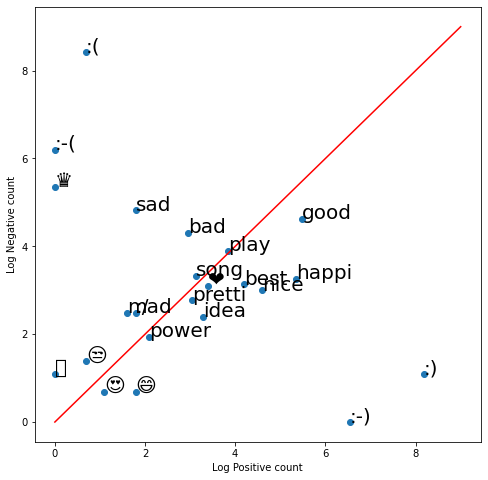

In [15]:
tokens = ['happi', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
          '❤', ':)', ':(', '😒',  '😬', '😄', '😍',  '♛',
          'song', 'idea', 'power', 'play', ':-)', ':-(', ':/']

data = plot_words(tokens, all_freqs)


* Emotions like `:)`, `:-)` lie on the bottom-right corner of the graph which means that they have a very high frequency on positive tweets and very low frequency on negative tweets (Emotion `:-)` does not appear at all on negative tweets). This means that they show a very positive sentiment on the tweets on which they appear. Also emojis like '😄', '😍' lie on the right side of the graph and show some positive sentiment. 
* On the left side we have tokens that show negative sentiment. Especially emotions like `:(`, `:-(` lie on the top-left corner of the graph which means that they have a very high frequency on negative tweets and a very low frequency on the positive tweets (emotion `:-(` does not appear at all on positive tweets). There are also emojis like `😒` which lie on the left side of the graph and as a result show some negative sentiment. The emoji `♛` seems also to be very negative!
* To conclude, this chart shows that emoticons and emojis are very important for sentiment analysis. Thus, we should not let preprocessing steps get rid of these symbols! Instead, we should include them in our training data and let the model learn from them. In the end we expect a better model performance since using emojis and emotions the model will easier distinguish between positive and negative tweets/messages.
* In this case we save the information about the frequencies of all tokens in positive and negative tweets. Since we found out that emojis and emotions are very important for sentiment analysis, we are also going to count how often they appear in the positive and negative tweets and add this information to our training data. 

* `top5_tokens` is a function which finds out the top 5 tokens of positive and negative tweets bzw the 5 tokens with the highest frequency on positive and negative tweets. Then we will check if any emoji/emotion is part of these lists.

In [16]:
def top5_tokens(label):
    counts = [all_freqs[x] for x in all_freqs if x[1] == label]
    counts.sort(reverse=True)
    top5_counts = counts[:5]
    top5_toks = [x[0] for x in all_freqs if x[1] == label and all_freqs[x] in top5_counts]
    
    return top5_toks

In [17]:
top5_positive_emojis = top5_tokens(1)
print('Top 5 Tokens of positive tweets : ' + str(top5_positive_emojis))
top5_negative_emojis = top5_tokens(0)
print('Top 5 Tokens of negative tweets : ' + str(top5_negative_emojis))

Top 5 Tokens of positive tweets : [':)', 'thank', 'love', ':D', ':-)']
Top 5 Tokens of negative tweets : [':(', "i'm", ':-(', '...', 'miss']


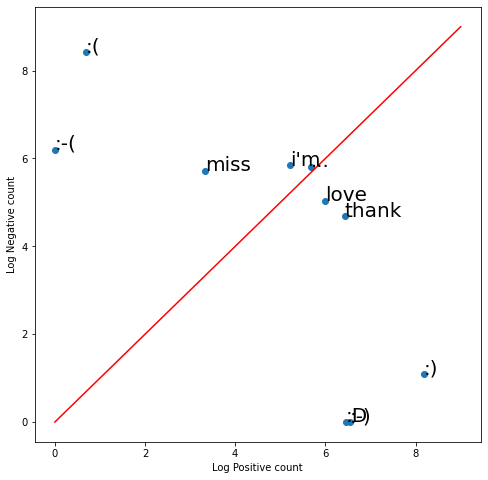

In [18]:
# plot top 5 tokens of positive and negative tweets

top5_tokens = top5_positive_emojis + top5_negative_emojis
data = plot_words(top5_tokens, all_freqs)

* As we see emotions like `:)`, `:-)`, `:D` are some the most frequent tokens in the positive tweets and `:(`, `:-(`, are some of the most frequent tokens on negative tweets. This means they they provide very useful and important information about the tweet sentiment.

* Since we are performing sentiment analysis we should only include emojis and emotions that convey positive or negative sentiment and remove the other types of emojis and emotions since we dont want to include useless information in our data. In this way we also reduce the training time. Usually emojis and emotions which show positive and negative sentiment are written in the end of the sentence and the other emojis in any other position. However, we should take a look if it is the case in some of the sentences from our dataset. First we are going find out which are the most important emojis and emotions (top30) based on their frequencies on positive and negative tweets.

* `top15_emojis_emotions` is a function which returns the most frequent emojis/emotions (top 15) in positive or negative tweets. 

In [19]:
def top15_emojis_emotions(label):
    counts_emoji_emotions = []

    emotions = ['=:O' ,':-/' ,':-' ,':-|' , ':-o', ':-P~' ,':-*', ':-))' ,':)', ':-)', 
                ':(', ':-(', ':/', ':D', ':p', '-_-', ';-)', ':<})', ':-||', ":'-('"]
    
    for key in all_freqs:
        if key[1] == label: 
            if emoji.is_emoji(key[0]) or key[0] in emotions:
                counts_emoji_emotions.append(all_freqs[key])
                
    counts_emoji_emotions.sort(reverse=True)
    top_counts = counts_emoji_emotions[:15]
    
    top_emojis_emotions = [] 
    for key in all_freqs:
        if key[1] == label:
            if emoji.is_emoji(key[0]) or key[0] in emotions:
                if all_freqs[key] in top_counts:
                    top_emojis_emotions.append(key[0])
    
    return top_emojis_emotions

In [20]:
# Show top 15 emojis/emotions in positive tweets
top15_emojis_emotions(1)

[':)',
 ':D',
 ':p',
 ':-)',
 '♥',
 '👉',
 '😘',
 '❤',
 '😊',
 '😁',
 '😂',
 '💜',
 '💙',
 '💚',
 '💕',
 '🍸']

In [21]:
# Show top 15 emojis/emotions in negative tweets
top15_emojis_emotions(0)

[':(',
 ':-(',
 '😩',
 '😭',
 '💜',
 '💕',
 '😊',
 '😂',
 '🏻',
 '♥',
 '💖',
 ':/',
 '😘',
 '❤',
 '💗',
 '😢',
 '💛',
 '😔',
 '😚',
 '💞',
 '😏']

Now lets check if emojis/emotions that convey positive or negative sentiment are placed in the end of the sentence in our dataset.

* `char_is_top_emoji_emotion` is a function which takes as argument a token or a character and return True if it part of the most frequent emojis/emotions, otherwise (let's say useless emojis/emotions). We will then go through the first 20 tweets and check in which position emojis and emotions are placed.

In [22]:
def char_is_top_emoji_emotion(token):
    emotions = ['=:O' ,':-/' ,':-' ,':-|' , ':-o', ':-P~' ,':-*', ':-))' ,':)', ':-)', 
                ':(', ':-(', ':/', ':D', ':p', '-_-', ';-)', ':<})', ':-||', ":'-('"]
    top_30_emojis_emotions = top15_emojis_emotions(1) + top15_emojis_emotions(0)
    if emoji.is_emoji(token) or token in emotions:
        if token in top_30_emojis_emotions:
            return True
    return False

In [23]:
for tweet in all_tweets[:20]:
    tokenized_tweet = process_tweet(tweet)
    for i in range(len(tokenized_tweet)):
        if(char_is_top_emoji_emotion(tokenized_tweet[i]) and i < len(tokenized_tweet) - 1):
            print(tweet)
            print()

@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!

@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!

@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!

yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

@BhaktisBanter @PallaviRuhail This one is irresistible :)
#FlipkartFashionFriday http://t.co/EbZ0L2VENM

@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.

Jgh , but we have to go to Bayan :D bye

Friend's lunch... yummmm :)
#Nostalgia #TBS #KU.

@RookieSenpai @arcadester it is the id conflict thanks for the help :D here's the screenshot of it working

Hello I need to know something can u fm me on Twitter?? — sure thing :) dm me x http://t.co

* As we see many emojis/emotions that convey positive or negative sentiment show up in different positions in the sentence, so it would not make sense if we remove emojis/emotions based on their positions in the sentence.
* I am going to include in our dictionary the most important emojis/emotions (top 30) which means the emojis/emotions that have highest positive or negative frequency and remove all other useless emojis and emotions. The amount of top emojis/emotions that we should consider is not fixed. In best case we should try different values and check how the model performs.

In [24]:
def build_freqs_remove(tweets, ys):    
    emotions = ['=:O' ,':-/' ,':-' ,':-|' , ':-o', ':-P~' ,':-*', ':-))' ,':)', ':-)', 
                ':(', ':-(', ':/', ':D', ':p', '-_-', ';-)', ':<})', ':-||', ":'-('"]
    top_30_emojis_emotions = top15_emojis_emotions(1) + top15_emojis_emotions(0)
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            if(emoji.is_emoji(word) or word in emotions):
                if word not in top_30_emojis_emotions:
                    continue
            
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1             
    return freqs

In [25]:
freqs_remove = build_freqs_remove(all_tweets, all_labels)
freqs_remove

{('followfriday', 1.0): 25,
 ('top', 1.0): 32,
 ('engag', 1.0): 7,
 ('member', 1.0): 16,
 ('commun', 1.0): 33,
 ('week', 1.0): 83,
 (':)', 1.0): 3568,
 ('hey', 1.0): 76,
 ('jame', 1.0): 7,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 97,
 ('call', 1.0): 37,
 ('contact', 1.0): 7,
 ('centr', 1.0): 2,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 8,
 ('assist', 1.0): 1,
 ('mani', 1.0): 33,
 ('thank', 1.0): 620,
 ('listen', 1.0): 16,
 ('last', 1.0): 47,
 ('night', 1.0): 68,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 51,
 ('track', 1.0): 5,
 ('scotland', 1.0): 2,
 ('congrat', 1.0): 21,
 ('yeaaah', 1.0): 1,
 ('yipppi', 1.0): 1,
 ('accnt', 1.0): 2,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 69,
 ('blue', 1.0): 9,
 ('tick', 1.0): 1,
 ('mark', 1.0): 1,
 ('fb', 1.0): 6,
 ('profil', 1.0): 2,
 ('15', 1.0): 5,
 ('day', 1.0): 246,
 ('one', 1.0): 129,
 ('irresist', 1.0): 2,
 ('flipkartfashionfriday', 1.0): 17,
 ('like', 1.0): 233,
 ('keep', 1.0): 68,
 ('love', 1.0): 400,


In [26]:
# Show the amount of emojis and emotions that were removed from the dictionary
len(all_freqs) - len(freqs_remove)

129

## Step 3 : Train Test Split

* Train test split: 20% will be in the test set, and 80% in the training set.

In [27]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

In [28]:
# create the labels for the tweets
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [29]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


## Step 4 : Extracting the features (convert text into numerical)

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    1. The first feature is the sum of frequencies of words (in a particular tweet) in positive tweets .
    2. The second feature is the sum of frequencies of words (in a particular tweet) in negative tweets.
* In general is feature1 > feature2 (frequency of positive words > frequency of negative words) it means that this tweet is rather a positive than a negative tweet. In training data we may also have tweets labeled as 0 (negative tweet) but have feature1 > feature2. 

In [30]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0),0)
        
    ### END CODE HERE ###
    assert(x.shape == (1, 3))
    return x

In [31]:
# Test extract_features function using a particular tweet

pd.DataFrame(extract_features('I am so happy -?? :)', freqs_remove))

,0,1,2
0,1.0,3779.0,27.0


In [32]:
def build_training_data(train_x, train_y):
    
    X_train = np.zeros((len(train_x), 3))
    for i in range(len(train_x)):
        X_train[i, :]= extract_features(train_x[i], freqs_remove)

    # training labels corresponding to X
    
    X_train = pd.DataFrame(data=X_train, columns = ['bias', 'Positive Frequency', 'Negative Frequency'])
    y_train = pd.Series(np.squeeze(train_y))
    train_data = pd.concat([X_train, y_train], axis=1)
    train_data.rename(columns={0 : 'Label'}, inplace=True)

    return train_data

In [33]:
train_data = build_training_data(train_x, train_y)

In [34]:
train_data.head()

,bias,Positive Frequency,Negative Frequency,Label
0,1.0,3764.0,72.0,1.0
1,1.0,4464.0,517.0,1.0
2,1.0,3759.0,160.0,1.0
3,1.0,3589.0,4.0,1.0
4,1.0,3915.0,280.0,1.0


## Step 7 : Outlier Removal

* A tweet should be positive if the frequency of positive words in that tweet is greater than the frequency of negative words and negative if frequency of negative words in that tweet is greater than the frequency of positive words.
Tweets in our training data that are labeled as negative but the frequency of positive words is greater than the frequency of negative words are considered outliers. We will remove them because we do not want our model to learn from noisy data (data that does not follow the general trend)

### 7A) Detecting Outliers

In [35]:
# show all tweets that are considered as outliers
outliers = train_data[((train_data['Positive Frequency'] > train_data['Negative Frequency']) & (train_data['Label'] == 0)) | ((train_data['Positive Frequency'] < train_data['Negative Frequency']) & (train_data['Label'] == 1))]
outliers

,bias,Positive Frequency,Negative Frequency,Label
309,1.0,36.0,58.0,1.0
320,1.0,264.0,395.0,1.0
354,1.0,356.0,547.0,1.0
492,1.0,264.0,395.0,1.0
518,1.0,270.0,304.0,1.0
542,1.0,3.0,7.0,1.0
657,1.0,634.0,1066.0,1.0
663,1.0,148.0,224.0,1.0
747,1.0,19.0,25.0,1.0
991,1.0,264.0,395.0,1.0


C:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Plot Tweets')

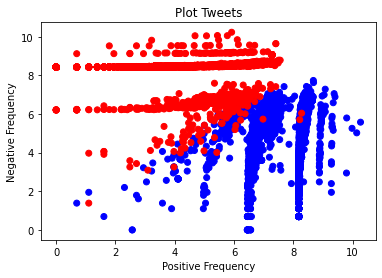

In [36]:
# Plot the data including the outliers (the columns of positive and negative frequencies)
# Blue points are positive tweets and red points are negative tweets.
c = ['blue' if label == 1 else 'red' for label in train_data['Label']]
plt.scatter(np.log(train_data['Positive Frequency']), np.log(train_data['Negative Frequency']), c=c)
plt.xlabel('Positive Frequency')
plt.ylabel('Negative Frequency')
plt.title('Plot Tweets')

* We can clearly see the outliers (points who are overlapping)

In [37]:
# Print the amount and percentage of outliers in the training data
print(len(outliers))
print(len(train_data))
print(len(outliers) / len(train_data))

52
8000
0.0065


* There are 55 outliers out of 8000 tweets


## 7B) Removing Outliers

In [38]:
train_data = train_data[~((train_data['Positive Frequency'] > train_data['Negative Frequency']) & (train_data['Label'] == 0)) | ((train_data['Positive Frequency'] < train_data['Negative Frequency']) & (train_data['Label'] == 1))]
train_data

,bias,Positive Frequency,Negative Frequency,Label
0,1.0,3764.0,72.0,1.0
1,1.0,4464.0,517.0,1.0
2,1.0,3759.0,160.0,1.0
3,1.0,3589.0,4.0,1.0
4,1.0,3915.0,280.0,1.0
...,...,...,...,...
7995,1.0,34.0,4629.0,0.0
7996,1.0,81.0,399.0,0.0
7997,1.0,184.0,989.0,0.0
7998,1.0,256.0,4855.0,0.0


C:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Plot Tweets')

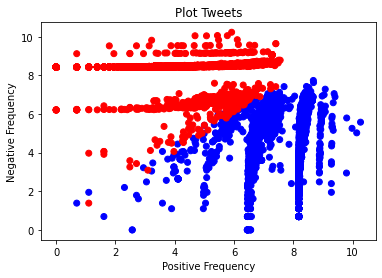

In [39]:
# Plot the data after removing outliers (the columns of positive and negative frequencies)
# Blue points are positive tweets and red points are negative tweets.
c = ['blue' if label == 1 else 'red' for label in train_data['Label']]
plt.scatter(np.log(train_data['Positive Frequency']), np.log(train_data['Negative Frequency']), c=c)
plt.xlabel('Positive Frequency')
plt.ylabel('Negative Frequency')
plt.title('Plot Tweets')

* There is no overlapping after removing the outliers.
* We use log transformation since the frequencies are in different scales and to have a clear visualization.
* We can clearly see that tweet points that have frequency of positive words greater than frequency of negative words lie on the right.
* We can see that the data is linearly separable and there are only few points which are overlapping. This means that LogisticRegression would perform well since it tries to separate the data using a straight line/hyperplane/linear decision boundary.

## Step 8 : Train a LogisticRegression Model

* `train_logistic_regression` trains a LogisticRegression model using the extracted features.

In [40]:
# Split the data into features and label

X_train = train_data.drop(['Label'], axis=1).copy()
y_train = train_data['Label'].copy()

In [41]:
X_train.head()

,bias,Positive Frequency,Negative Frequency
0,1.0,3764.0,72.0
1,1.0,4464.0,517.0
2,1.0,3759.0,160.0
3,1.0,3589.0,4.0
4,1.0,3915.0,280.0


In [42]:
y_train

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
7995    0.0
7996    0.0
7997    0.0
7998    0.0
7999    0.0
Name: Label, Length: 7977, dtype: float64

In [43]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression():
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

In [44]:
lr = train_logistic_regression()
lr

LogisticRegression()

## Step 9 : Evaluate the model using test set

* `build_test_data` builds the test dataset. <br>
Important Note : We use the freqs dictionary that we created during training. We must not create it again using the test data since we assume we dont know anything from test data.

In [45]:
def build_test_data(test_x, test_y, freqs):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    X_test = np.zeros((len(test_x), 3))
    for i in range(len(test_x)):
        X_test[i, :] = extract_features(test_x[i], freqs)

    # test labels corresponding to X
    
    X_test = pd.DataFrame(data=X_test, columns = ['bias', 'Positive Frequency', 'Negative Frequency'])
    y_test = pd.Series(np.squeeze(test_y))
    test_data = pd.concat([X_test, y_test], axis=1)
    test_data.rename(columns={0 : 'Label'}, inplace=True)
        
    return test_data

In [46]:
test_data = build_test_data(test_x, test_y, freqs_remove)

In [47]:
test_data.head()

,bias,Positive Frequency,Negative Frequency,Label
0,1.0,4068.0,522.0,1.0
1,1.0,4081.0,507.0,1.0
2,1.0,1729.0,397.0,1.0
3,1.0,3972.0,473.0,1.0
4,1.0,1019.0,37.0,1.0


In [48]:
# Outlier Removal
#test_data = test_data[~((test_data['Positive Frequency'] > test_data['Negative Frequency']) & (test_data['Label'] == 0)) | ((test_data['Positive Frequency'] < test_data['Negative Frequency']) & (test_data['Label'] == 1))]

In [49]:
X_test = test_data.drop(['Label'], axis=1)
y_test = test_data['Label']

* `evaluate_logistic_regression` evaluates the trained Logistic Regression Estimators using classification_report which contains the accuracy, f1_scores, precisions, recalls. 

In [50]:
from sklearn.metrics import classification_report

def evaluate_logistic_regression(model):
    pred_test = model.predict(X_test)
    print(classification_report(y_test, pred_test))
    

In [51]:
evaluate_logistic_regression(lr)

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1000
         1.0       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



## Step 10 : Make predictions on new tweets

* `predict_tweet` predicts using our trained Logistic Regression model and the freq dictionary (built during training) whether the tweet is positive or negative 

In [52]:
def predict_tweet(tweet, freqs, model):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet,freqs)
    
    # make the prediction using x and theta
    pred = model.predict(x)
    if pred[0] == 1:
        return 'Positive Tweet', pred[0]
    else:
        return 'Negative Tweet', pred[0]

In [53]:
# Predict one single tweet

tweet = 'I am so happy'
predict_tweet(tweet, freqs_remove, lr)

('Positive Tweet', 1.0)

In [54]:
# Lets write some positive tweets and include emojis/emotions and check how the model performs
pos_tweets = ['I find this movie very interesting 😄', 
              'Who would not like this superstar 😍', 
              'Today i feel much better :):)',
              'I am very satisfied with this video :-)'
              ]
for tweet in pos_tweets:
    print(f'Tweet : {tweet} - Prediction : {predict_tweet(tweet, freqs_remove, lr)}')

Tweet : I find this movie very interesting 😄 - Prediction : ('Positive Tweet', 1.0)
Tweet : Who would not like this superstar 😍 - Prediction : ('Positive Tweet', 1.0)
Tweet : Today i feel much better :):) - Prediction : ('Positive Tweet', 1.0)
Tweet : I am very satisfied with this video :-) - Prediction : ('Positive Tweet', 1.0)


In [55]:
neg_tweets = ['I find this movie not interesting',
              'I find this movie not interesting :(']
for tweet in neg_tweets:
    print(f'Tweet : {tweet} - Prediction : {predict_tweet(tweet, freqs_remove, lr)}')
    

pos_tweets = ['Today i feel much better',
              'Today i feel much better :):)']

for tweet in pos_tweets:
    print(f'Tweet : {tweet} - Prediction : {predict_tweet(tweet, freqs_remove, lr)}')

Tweet : I find this movie not interesting - Prediction : ('Positive Tweet', 1.0)
Tweet : I find this movie not interesting :( - Prediction : ('Negative Tweet', 0.0)
Tweet : Today i feel much better - Prediction : ('Negative Tweet', 0.0)
Tweet : Today i feel much better :):) - Prediction : ('Positive Tweet', 1.0)


* I will write the same tweet. In the first one i will not include any emoji and the second one i will include the sad emoji `:(`. Without using emoji the model will classify it as positive tweet but when adding the sad emoji it will be classified as negative tweet. This is an example which shows that emojis play a very important role when it comes to sentiment analysis. The same happens with the second example when adding the emoji `:)`.


## Step 10 : Error Analysis

In this part we will see some tweets that your model misclassified. Why did the misclassifications happen ? Specifically what kind of tweets does the model misclassify?

In [56]:
print('Label Predicted Tweet')
for x,y in zip(test_x, test_y):
    message, pred = predict_tweet(x, freqs_remove, lr)
    
    if pred != y:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, pred, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))
        print()

Label Predicted Tweet
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.00000000	b"i'm play brain dot braindot"

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/aOKldo3GMj http://t.co/xWCM9qyRG5
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.00000000	b"i'm play brain dot braindot"

THE TWEET IS: I'm playing Brain Dots : ) #BrainDots http://t.co/R2JBO8iNww http://t.co/ow5BBwdEMY
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.00000000	b"i'm play brain dot braindot"

THE TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.00000000	b'uff itna miss karhi thi ap :p'

THE TWEET IS: Get in the bin, OSX/Chrome/Voiceover &gt;:( http://t.co/0bcvA6YjWu
THE PROCESSED TWEET IS: ['get', 'bin', 'osx', 'chrome', 'voiceov', '>:(']
0	1.00000000	b'get bin osx chrome voi